# Age Estimation task

## Imports

In [1]:
import numpy as np
import pandas as pd

import scipy

import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import seaborn as sns

import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

# %matplotlib widget

## Constants

In [2]:
FILE_DEVELOPMENT = "Dataset/development.csv"
FILE_EVALUATION = "Dataset/evaluation.csv"
AUDIOS_DEVELOPMENT = "Dataset/audios_development/"
AUDIOS_EVALUATION = "Dataset/audios_evaluation/"

precisionLog = {
    'mean_pitch':2, 
    'max_pitch':2, 
    'min_pitch':3, 
    'jitter':2, 
    'shimmer':2, 
    'energy':1, 
    'zcr_mean':2, 
    'spectral_centroid_mean':2,
    'tempo':3,
    'hnr':0
}

precisionLinear = {
    'mean_pitch':-1, 
    'max_pitch':-2, 
    'min_pitch':0, 
    'jitter':3, 
    'shimmer':3, 
    'energy':3, 
    'zcr_mean':2, 
    'spectral_centroid_mean':-2,
    'tempo':3,
    'hnr':0
}

## Data reading

In [3]:
dev_original_df = pd.read_csv(FILE_DEVELOPMENT, header=0, index_col=0)
eval_original_df = pd.read_csv(FILE_EVALUATION, header=0, index_col=0)

audio_dev = os.listdir(AUDIOS_DEVELOPMENT)
audio_eval = os.listdir(AUDIOS_EVALUATION)

## Tabular Data Exploration

In [4]:
# display(dev_original_df.head())

display(f"Total number of nan in development: {dev_original_df.isna().sum().sum()}")
display(f"Total number of nan in evaluation: {eval_original_df.isna().sum().sum()}")

desc_dev_df = dev_original_df.describe()
desc_eval_df = eval_original_df.describe()

sampling_rate = dev_original_df['sampling_rate'].iloc[0]

# display(desc_dev_df.loc['std', 'sampling_rate'])
# display(desc_eval_df.loc['std', 'sampling_rate'])

dev_df = dev_original_df.drop('sampling_rate', axis=1)
eval_df = eval_original_df.drop('sampling_rate', axis=1)

ages_df = dev_df[['age']]
path_dev_df = dev_df[['path']]
path_eval_df = eval_df[['path']]

dev_df = dev_df.drop(['path'], axis=1)
eval_df = eval_df.drop('path', axis=1)

display(dev_df.head())
display(eval_df.head())

'Total number of nan in development: 0'

'Total number of nan in evaluation: 0'

age  gender   ethnicity  mean_pitch  max_pitch  min_pitch    jitter  \
Id                                                                         
0   24.0  female      arabic   1821.6906  3999.7170  145.43066  0.013795   
1   22.5  female   hungarian   1297.8187  3998.8590  145.37268  0.025349   
2   22.0  female  portuguese   1332.8524  3998.8025  145.42395  0.019067   
3   22.0  female     english   1430.3499  3998.4510  147.98083  0.017004   
4   22.0    male       dutch   1688.7234  3998.6113  145.44772  0.028027   

     shimmer    energy  zcr_mean  spectral_centroid_mean           tempo  \
Id                                                                         
0   0.082725  0.002254  0.210093             3112.257251  [151.99908088]   
1   0.096242  0.007819  0.078849             1688.016389  [129.19921875]   
2   0.119456  0.002974  0.105365             2576.901706  [117.45383523]   
3   0.102389  0.022371  0.173701             3269.751413  [117.45383523]   
4   0.124831  0.005369  0.107279             1930.897375  [112.34714674]   

           hnr  num_words  num_characters  num_pauses  silence_duration  
Id                                                                       
0  -123.999726         69             281          39         23.846893  
1   -86.928478         69             281          21         19.388662  
2   -98.450670         69             281           1         21.640998  
3   -56.459762         69             281           9         19.644127  
4   -80.349204         69             281          11         18.041905

gender ethnicity  mean_pitch  max_pitch  min_pitch    jitter   shimmer  \
Id                                                                           
0     male   spanish  1056.91740  3945.1610  145.38750  0.022082  0.171076   
1     male     xiang  1231.84570  3999.1720  145.56432  0.026571  0.132585   
2     male      igbo   958.29065  3445.4490  145.67374  0.018044  0.096289   
3   female   spanish  1396.54170  3998.8948  145.41223  0.027290  0.088901   
4     male   spanish  1633.86770  3999.7632  145.36313  0.021621  0.103855   

      energy  zcr_mean  spectral_centroid_mean           tempo         hnr  \
Id                                                                           
0   0.003136  0.032963             1549.607050   [80.74951172] -116.662338   
1   0.006783  0.123895             2344.817369   [89.10290948]  -78.253824   
2   0.004478  0.089149             1939.574896    [123.046875]  -71.630742   
3   0.014893  0.097054             1832.059113    [123.046875] -101.533013   
4   0.001369  0.140950             2534.611168  [112.34714674] -134.914070   

    num_words  num_characters  num_pauses  silence_duration  
Id                                                           
0          69             281           2         38.198503  
1          69             281          27         29.605442  
2           6              22           2          2.275556  
3          69             281          31         22.151837  
4          69             281          35         22.430476

In [5]:
temp = dev_df['num_words'].value_counts()
display(temp)

et = dev_df['ethnicity'].value_counts()
et

num_words
69    1710
0      409
4      257
3      158
5      148
2       78
1       66
6       62
7       39
8        2
9        2
12       1
10       1
Name: count, dtype: int64

ethnicity
igbo        1081
english      579
arabic       102
mandarin      65
french        63
            ... 
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, Length: 165, dtype: int64

## Preprocess tabular data

### Encoding

#### Ethnicity

In [6]:
def encode_english(X_df):
    X_df['ethnicity'] = X_df['ethnicity'].apply(lambda x: 1 if x == 'english' else 0)
    return X_df

In [7]:
def encode_ethnicity(X_df, ethnie):
    etna = pd.DataFrame(1, columns=ethnie, index=X_df.index)

    aggregated_ethnicity_df = X_df.copy()
    aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'].isin(ethnie)), 'ethnicity'] = 'others'

    for etnia in ethnie:
        aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = etna[etnia]

        # aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = 1
        aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'] == etnia), etnia] = 0

    # encoded_ethnicity = pd.get_dummies(aggregated_ethnicity_df['ethnicity'], dtype=int)

    try:
        aggregated_ethnicity_df = aggregated_ethnicity_df.drop(columns=['ethnicity'], axis=1)
    except KeyError:
        pass

    return aggregated_ethnicity_df

In [8]:
enticity_df = dev_df['ethnicity'].value_counts().sort_values(ascending=False)

median_et = enticity_df.median()
display(enticity_df[enticity_df == 1].shape)
display(enticity_df.head(20))
display(enticity_df.tail(10))
# enticity_df[enticity_df > median_et].plot()

etnie_chosen = sorted(list(set(enticity_df[enticity_df > median_et].index)))
display(etnie_chosen)
display(etnie_chosen.__len__())

(58,)

ethnicity
igbo          1081
english        579
arabic         102
mandarin        65
french          63
korean          52
portuguese      48
russian         48
dutch           47
german          36
polish          34
italian         33
urhobo          32
japanese        27
ibibio          27
macedonian      26
farsi           23
cantonese       23
igala           22
amharic         20
Name: count, dtype: int64

ethnicity
faroese        1
nandi          1
nuer           1
dinka          1
mortlockese    1
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, dtype: int64

['albanian',
 'amharic',
 'arabic',
 'armenian',
 'azerbaijani',
 'bambara',
 'belarusan',
 'bengali',
 'bosnian',
 'bulgarian',
 'cantonese',
 'catalan',
 'congolese',
 'croatian',
 'czech',
 'danish',
 'dari',
 'dutch',
 'english',
 'estonian',
 'fanti',
 'farsi',
 'fijian',
 'finnish',
 'french',
 'ga',
 'georgian',
 'german',
 'greek',
 'gujarati',
 'hausa',
 'hebrew',
 'hindi',
 'hungarian',
 'ibibio',
 'icelandic',
 'igala',
 'igbo',
 'ika',
 'indonesian',
 'italian',
 'japanese',
 'kambaata',
 'kazakh',
 'khmer',
 'kikuyu',
 'kiswahili',
 'korean',
 'krio',
 'kurdish',
 'lao',
 'latvian',
 'lithuanian',
 'macedonian',
 'malay',
 'malayalam',
 'mandarin',
 'marathi',
 'mende',
 'miskito',
 'mongolian',
 'nepali',
 'nigerian',
 'norwegian',
 'obudu',
 'oromo',
 'pashto',
 'polish',
 'portuguese',
 'pulaar',
 'punjabi',
 'romanian',
 'russian',
 'tiv',
 'urhobo',
 'yoruba']

76

#### Gender

In [9]:
GenderMapper = {
    'male': 1,
    'female': -1
}

def encode_gender(X_df:pd.DataFrame, mapper):
    encoded_df = X_df.copy()
    for gender, value in mapper.items():
        encoded_df.loc[encoded_df['gender'] == gender, 'gender'] = value

    encoded_df.loc[encoded_df['gender'] == 'famale', 'gender'] = -1

    encoded_df['gender'] = encoded_df['gender'].astype(float)
    return encoded_df

#### Tempo

In [10]:
# display(encoded_gender_etnicity_df['tempo'])

def encode_tempo(X_df):
    encoded_df = X_df.copy()
    encoded_df['tempo'] = encoded_df['tempo'].map(lambda x: float(x.strip('[').strip(']')))
    return encoded_df


#### Results

In [11]:
display(eval_df.loc[eval_df['ethnicity'].isin(etnie_chosen), 'ethnicity'].value_counts())

# FOR NOW, WE WILL DROP ETHNICITY #TODO:

# step1_dev_df = encode_ethnicity(dev_df, etnie_chosen)
# step1_eval_df = encode_ethnicity(eval_df, etnie_chosen)

step1_dev_df = encode_english(dev_df)
step1_eval_df = encode_english(eval_df)

# step1_dev_df = dev_df.copy()
# step1_eval_df = eval_df.copy()

# display(dev_df.head(5))
# display(eval_df.head(5))

# step1_eval_df = encode_ethnicity(eval_df, etnie_chosen)

# display(step1_dev_df.head())
# display(step1_eval_df.head())

# step1_eval_df['gender'].value_counts()

step2_dev_df = encode_gender(step1_dev_df, GenderMapper)
step2_eval_df = encode_gender(step1_eval_df, GenderMapper)

# display(step2_dev_df.head(5))
# display(step2_eval_df.head(5))

step3_dev_df = encode_tempo(step2_dev_df)
step3_eval_df = encode_tempo(step2_eval_df)

display(step3_dev_df.head(5))
# display(step3_eval_df.head(5))

# step3_dev_df = step3_dev_df.drop(columns=['ethnicity'], axis=1)
# step3_eval_df = step3_eval_df.drop(columns=['ethnicity'], axis=1)

# display(step3_dev_df.head(5))

# display(step3_eval_df[step3_eval_df['yoruba'] == 1])
# display(eval_df.loc[75, :])

display(step3_dev_df.describe())
step3_dev_df.columns


ethnicity
igbo         232
yoruba         5
igala          4
ibibio         2
congolese      1
urhobo         1
nigerian       1
hausa          1
Name: count, dtype: int64

age  gender  ethnicity  mean_pitch  max_pitch  min_pitch    jitter  \
Id                                                                        
0   24.0    -1.0          0   1821.6906  3999.7170  145.43066  0.013795   
1   22.5    -1.0          0   1297.8187  3998.8590  145.37268  0.025349   
2   22.0    -1.0          0   1332.8524  3998.8025  145.42395  0.019067   
3   22.0    -1.0          1   1430.3499  3998.4510  147.98083  0.017004   
4   22.0     1.0          0   1688.7234  3998.6113  145.44772  0.028027   

     shimmer    energy  zcr_mean  spectral_centroid_mean       tempo  \
Id                                                                     
0   0.082725  0.002254  0.210093             3112.257251  151.999081   
1   0.096242  0.007819  0.078849             1688.016389  129.199219   
2   0.119456  0.002974  0.105365             2576.901706  117.453835   
3   0.102389  0.022371  0.173701             3269.751413  117.453835   
4   0.124831  0.005369  0.107279             1930.897375  112.347147   

           hnr  num_words  num_characters  num_pauses  silence_duration  
Id                                                                       
0  -123.999726         69             281          39         23.846893  
1   -86.928478         69             281          21         19.388662  
2   -98.450670         69             281           1         21.640998  
3   -56.459762         69             281           9         19.644127  
4   -80.349204         69             281          11         18.041905

age       gender    ethnicity   mean_pitch    max_pitch  \
count  2933.000000  2933.000000  2933.000000  2933.000000  2933.000000   
mean     27.897886    -0.001023     0.197409  1189.536569  3779.570485   
std      13.093316     1.000170     0.398111   414.193673   532.847869   
min       6.000000    -1.000000     0.000000   346.974330   935.515560   
25%      19.000000    -1.000000     0.000000   818.922360  3948.234400   
50%      23.000000    -1.000000     0.000000  1208.998300  3998.397200   
75%      32.000000     1.000000     0.000000  1523.777700  3999.485400   
max      97.000000     1.000000     1.000000  2724.892800  3999.792500   

         min_pitch       jitter      shimmer       energy     zcr_mean  \
count  2933.000000  2933.000000  2933.000000  2933.000000  2933.000000   
mean    146.934930     0.021190     0.107741     0.005208     0.104774   
std       3.757917     0.006626     0.029005     0.006074     0.051646   
min     145.349140     0.007292     0.045205     0.000028     0.015947   
25%     145.419140     0.016734     0.087378     0.001960     0.060733   
50%     145.622010     0.020525     0.104697     0.003716     0.098964   
75%     146.820890     0.024558     0.124993     0.006338     0.139559   
max     202.040700     0.096153     0.265167     0.129114     0.335976   

       spectral_centroid_mean        tempo          hnr    num_words  \
count             2933.000000  2933.000000  2933.000000  2933.000000   
mean              2176.369847   125.085771   -74.526288    41.307535   
std                578.925294    33.812698    38.446856    32.782431   
min                692.116731    51.679688  -193.693345     0.000000   
25%               1740.756716   103.359375  -104.555692     4.000000   
50%               2150.814043   117.453835   -84.415550    69.000000   
75%               2566.190670   143.554688   -40.339359    69.000000   
max               4144.132595   287.109375    12.403661    69.000000   

       num_characters   num_pauses  silence_duration  
count     2933.000000  2933.000000       2933.000000  
mean       167.936243    12.423116         13.501159  
std        133.816974    14.273205         10.839142  
min          0.000000     1.000000          0.668345  
25%         14.000000     1.000000          1.732925  
50%        281.000000     8.000000         17.368526  
75%        281.000000    20.000000         21.408798  
max        281.000000    97.000000         83.777596

Index(['age', 'gender', 'ethnicity', 'mean_pitch', 'max_pitch', 'min_pitch',
       'jitter', 'shimmer', 'energy', 'zcr_mean', 'spectral_centroid_mean',
       'tempo', 'hnr', 'num_words', 'num_characters', 'num_pauses',
       'silence_duration'],
      dtype='object')

### Behavior analysis and $log_{10}$ scaling

#### Insight

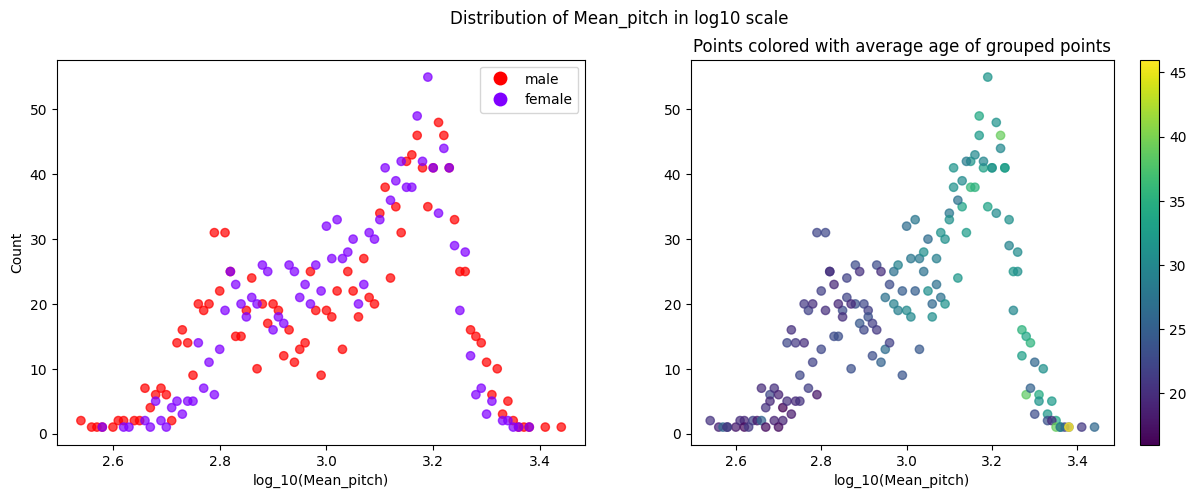

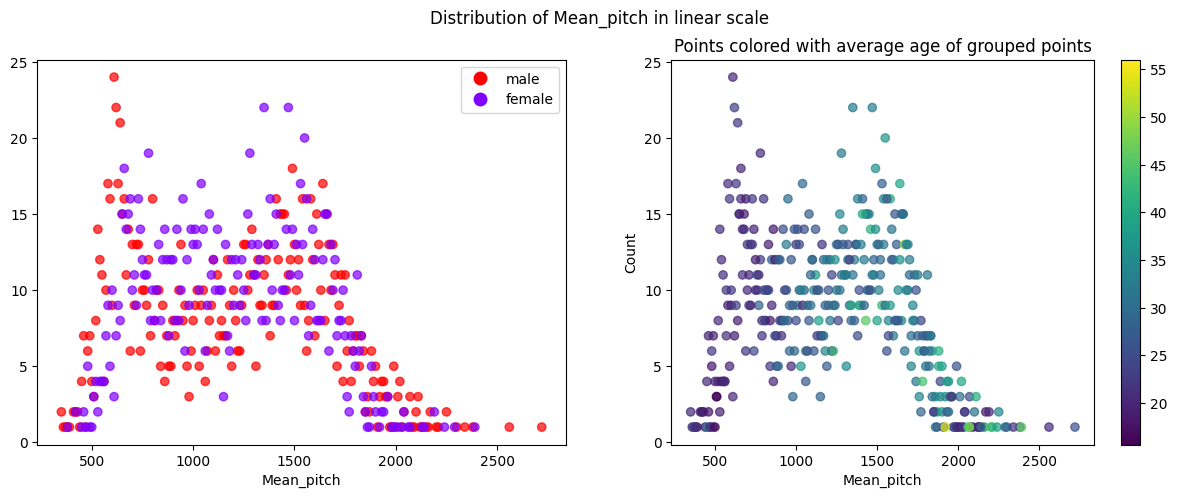

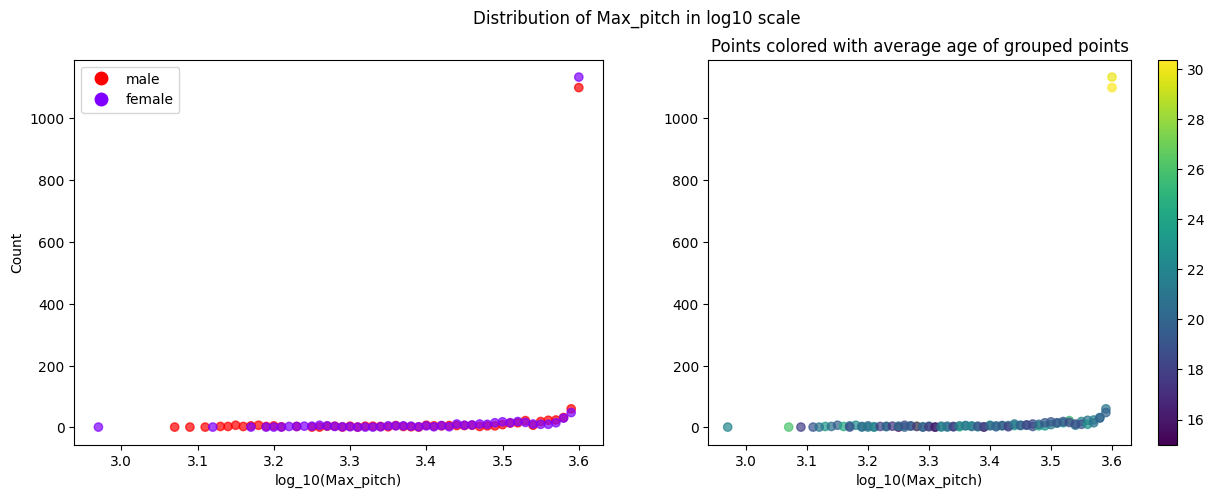

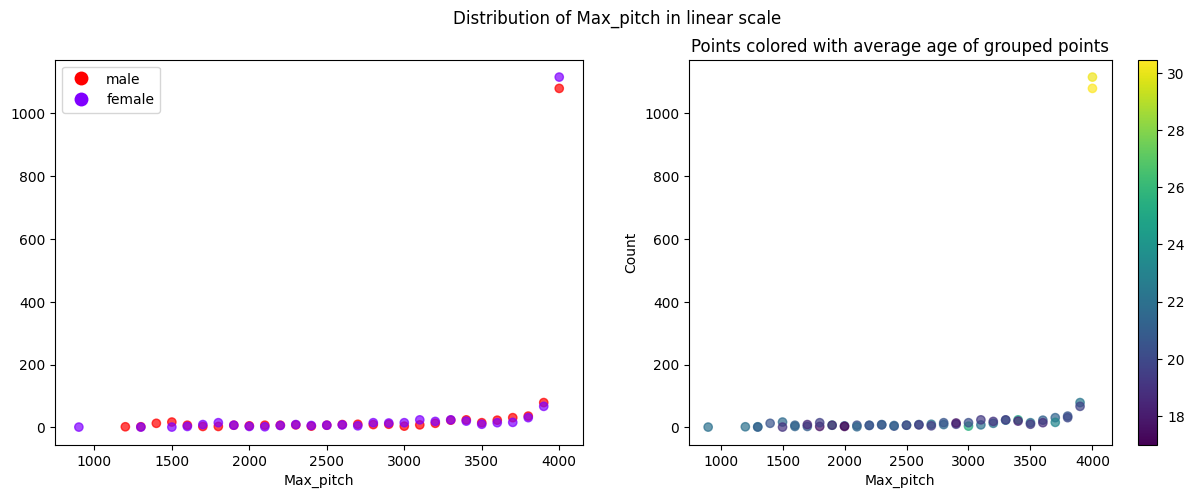

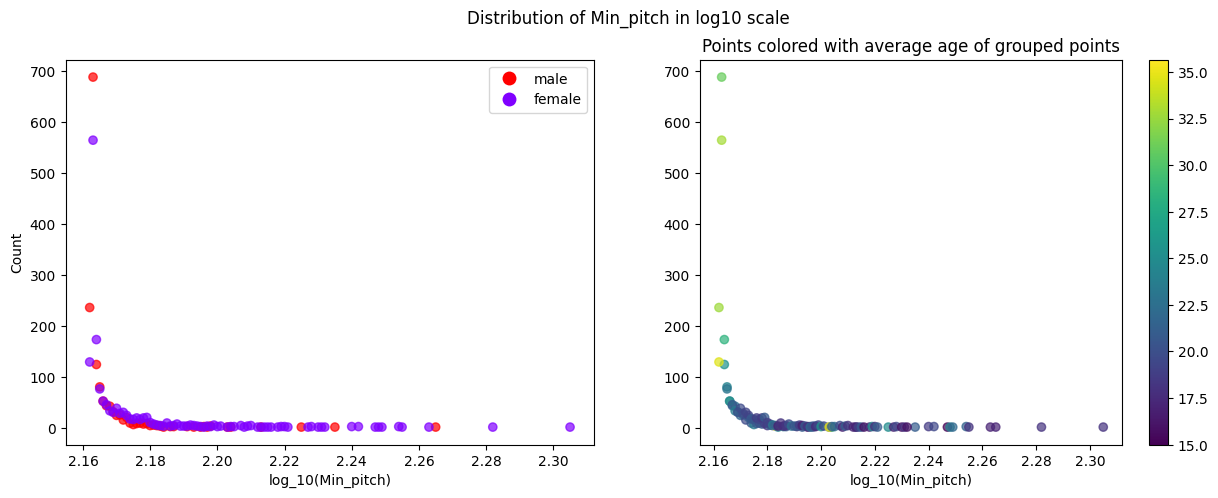

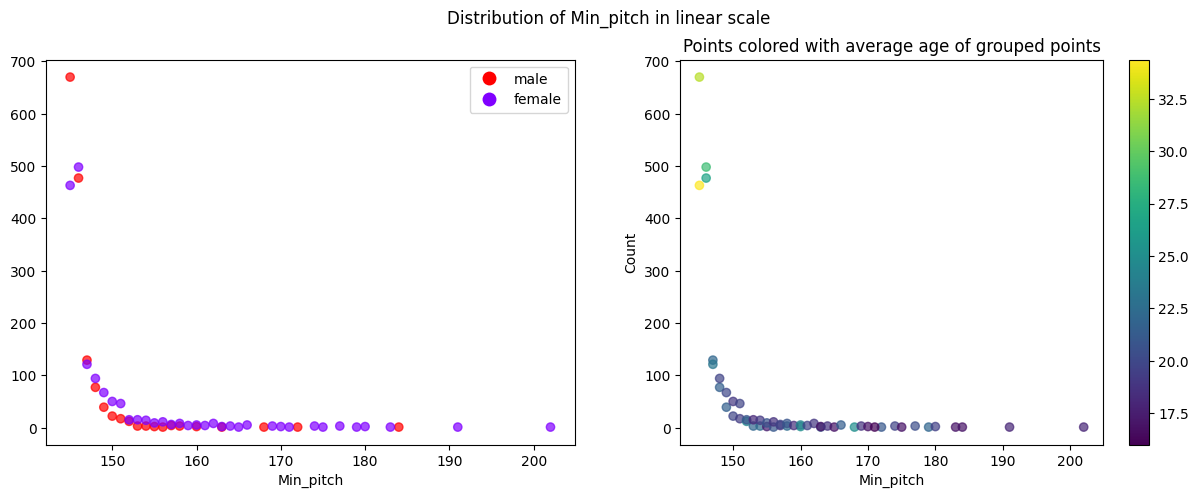

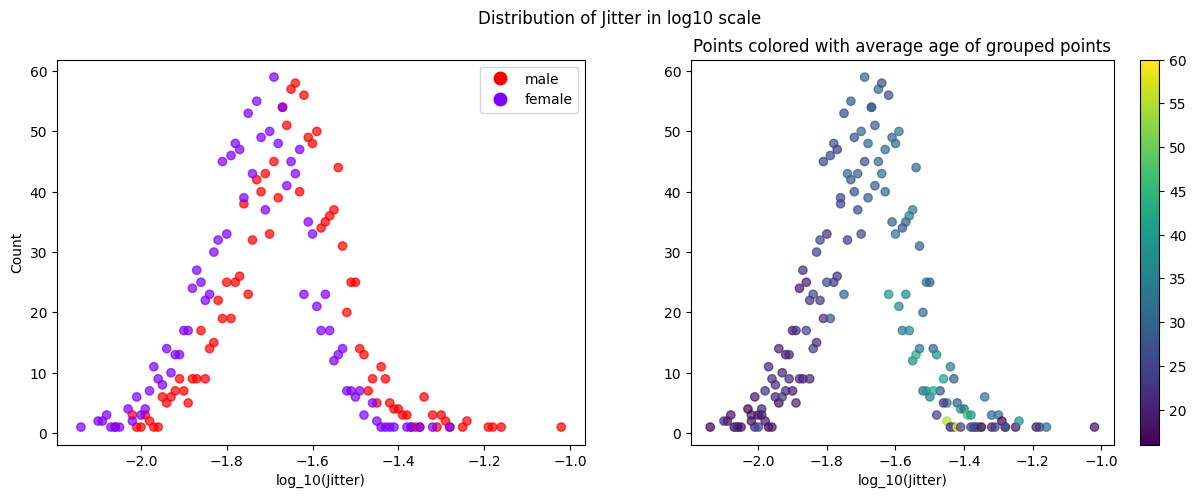

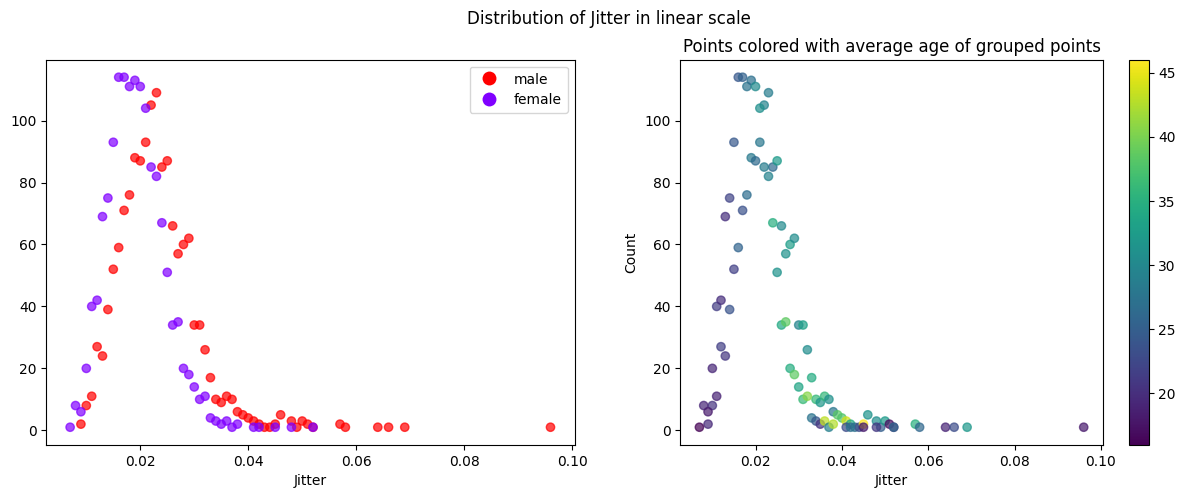

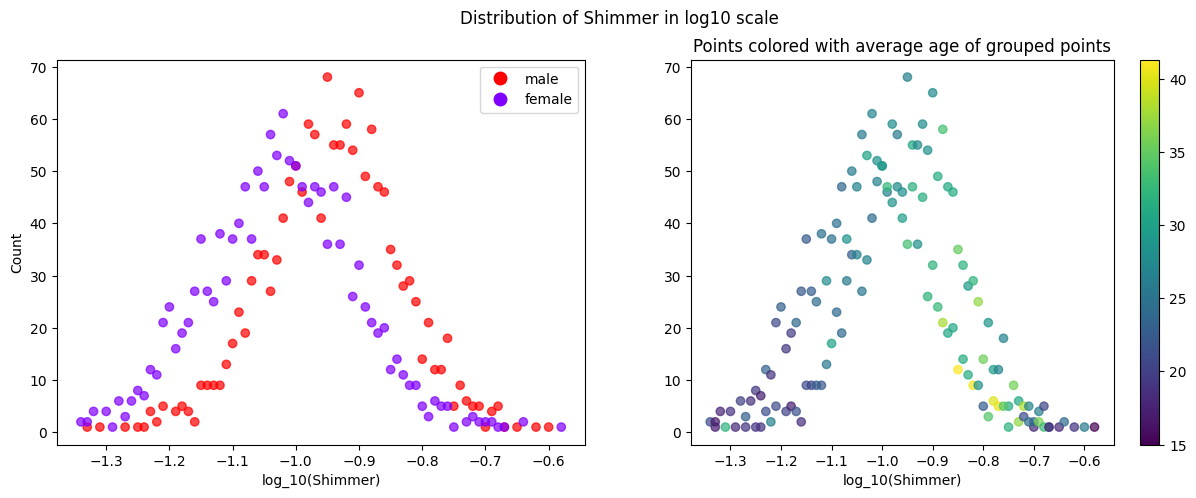

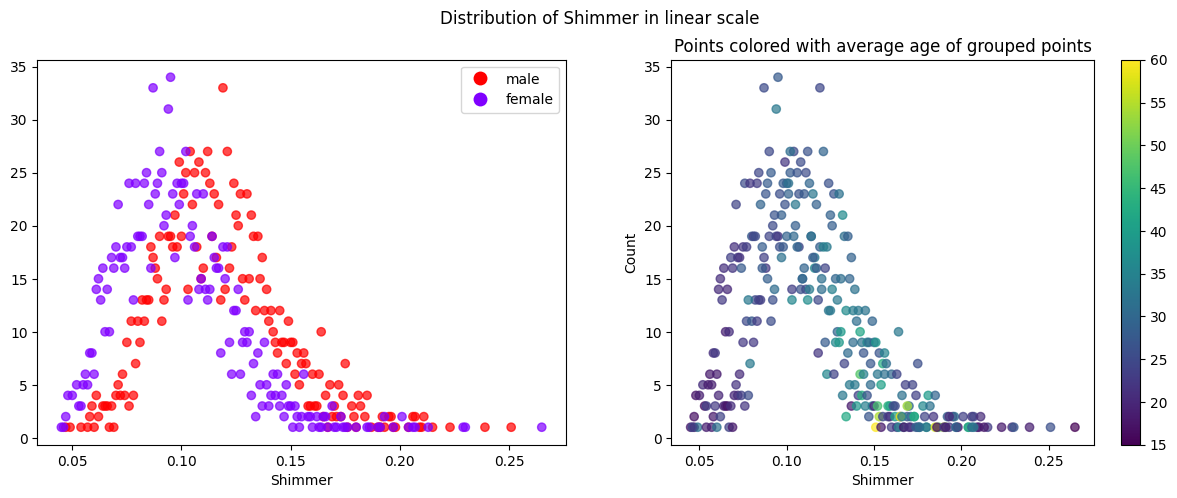

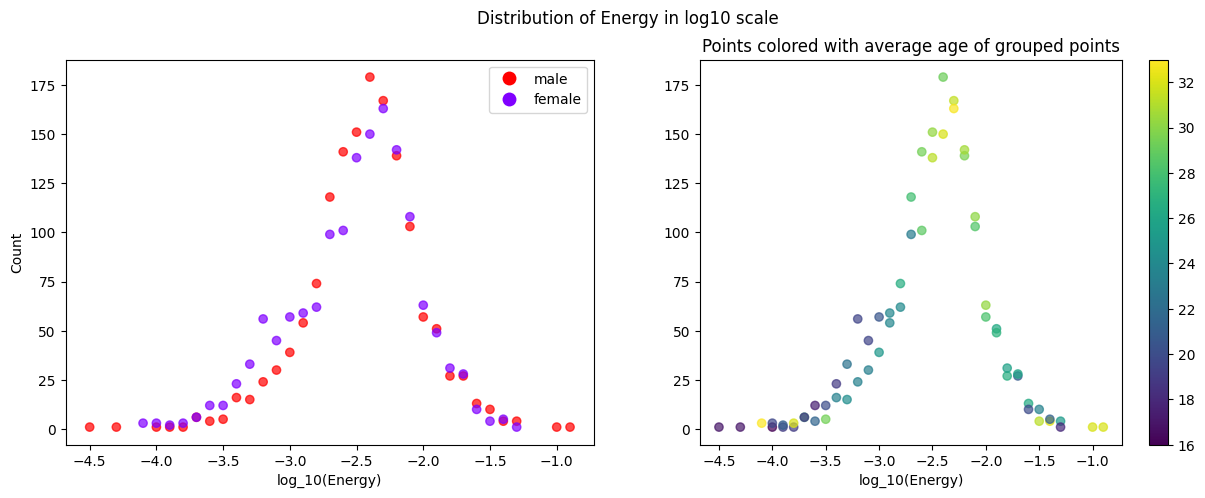

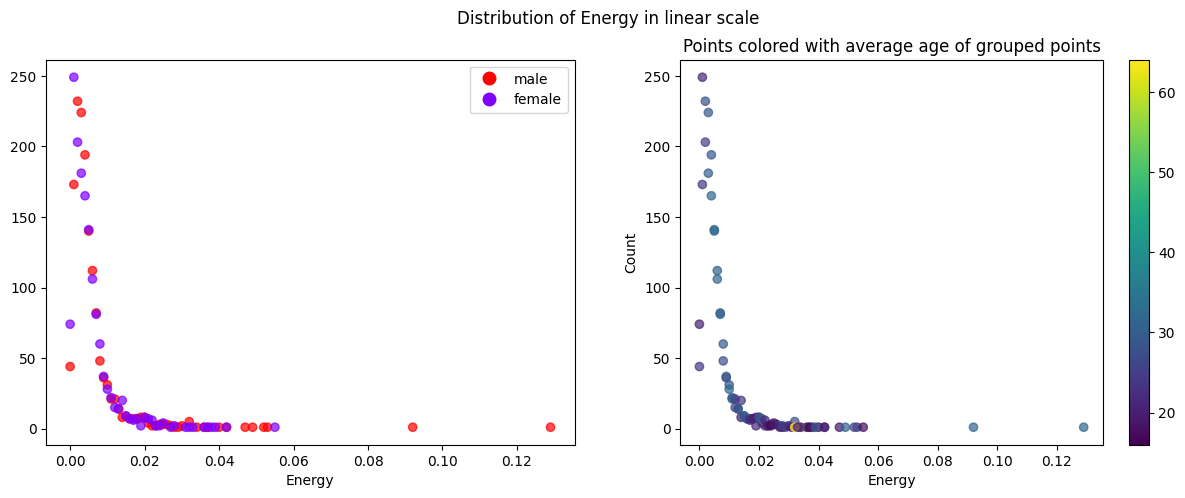

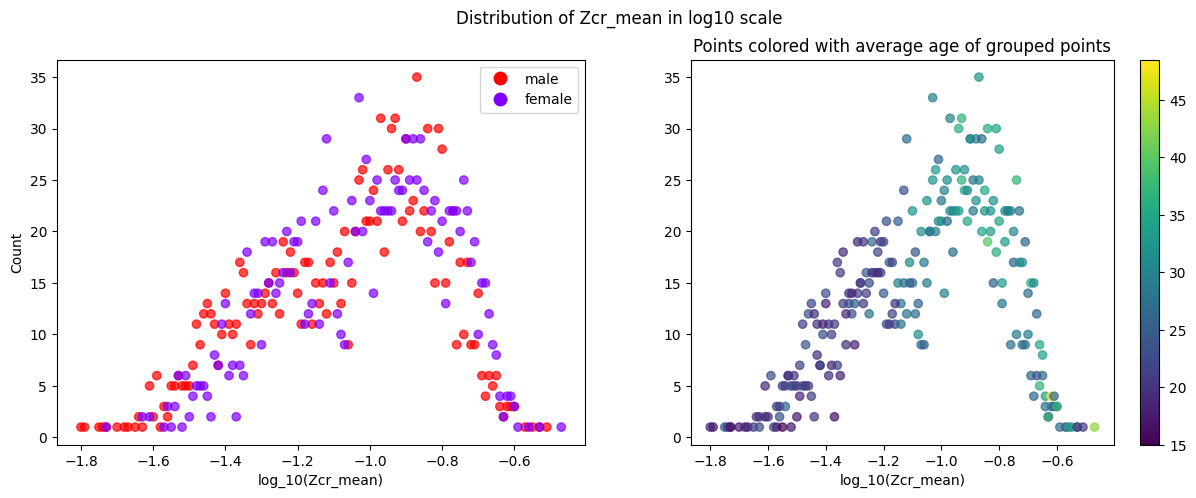

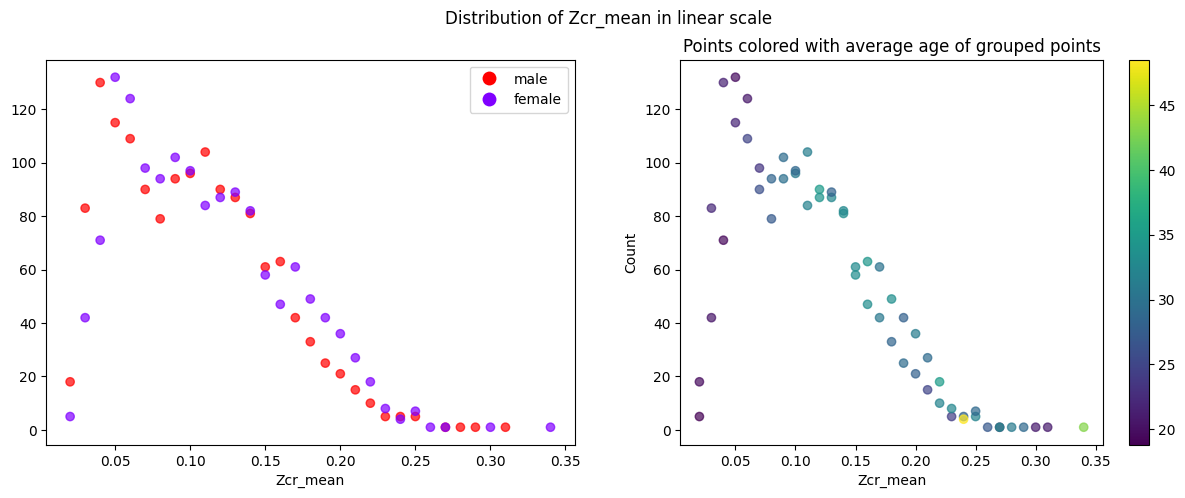

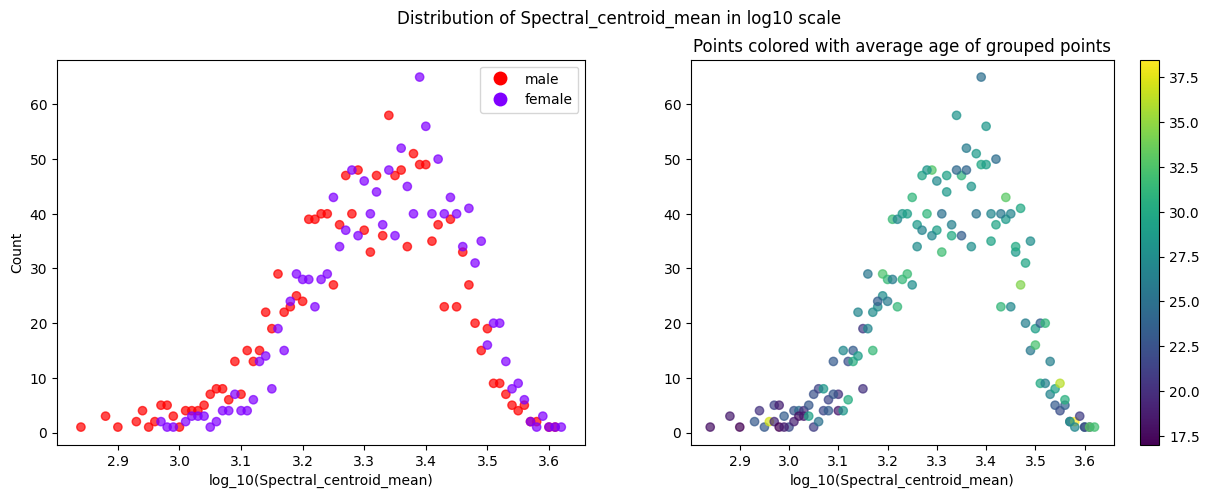

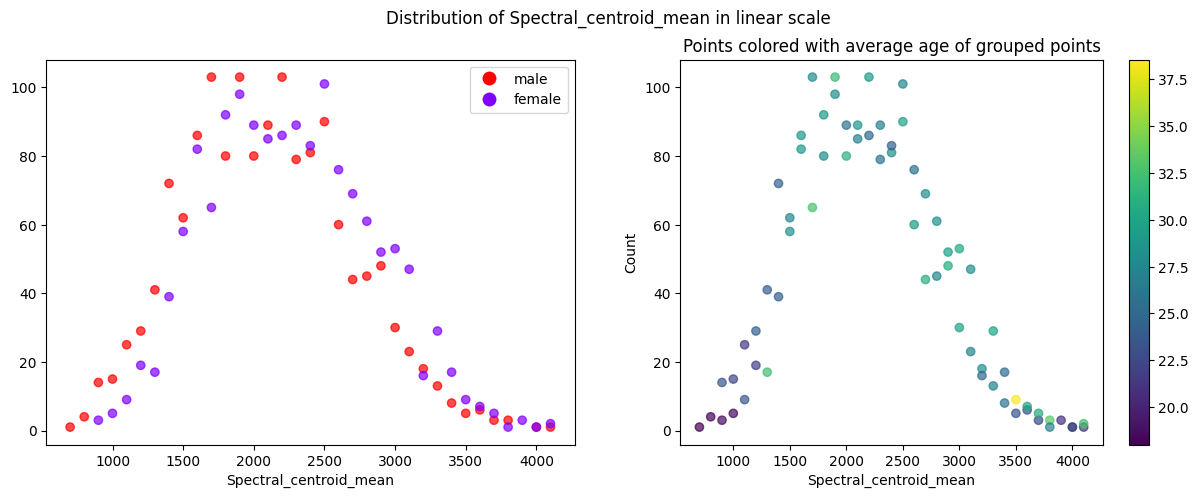

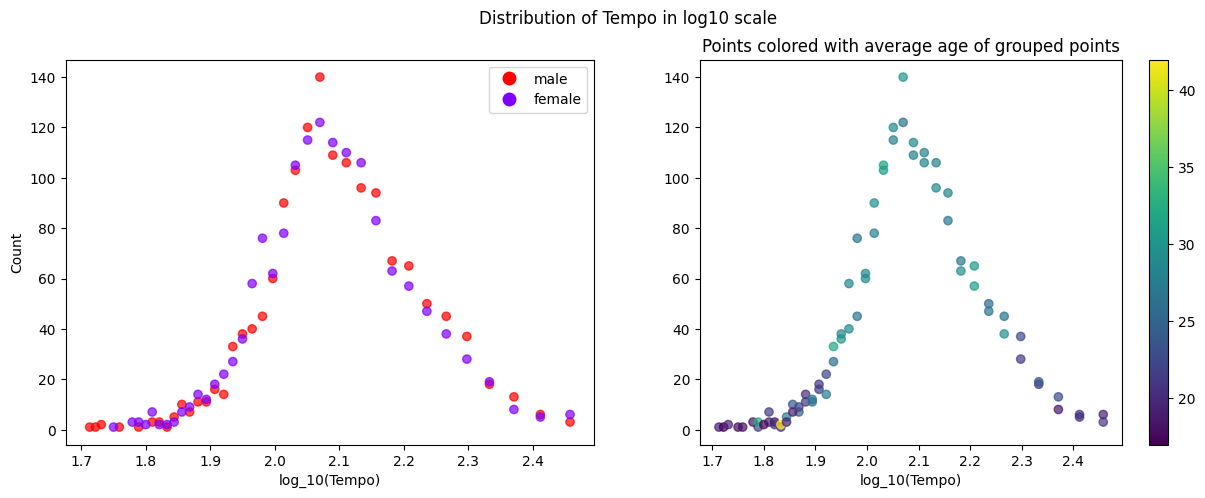

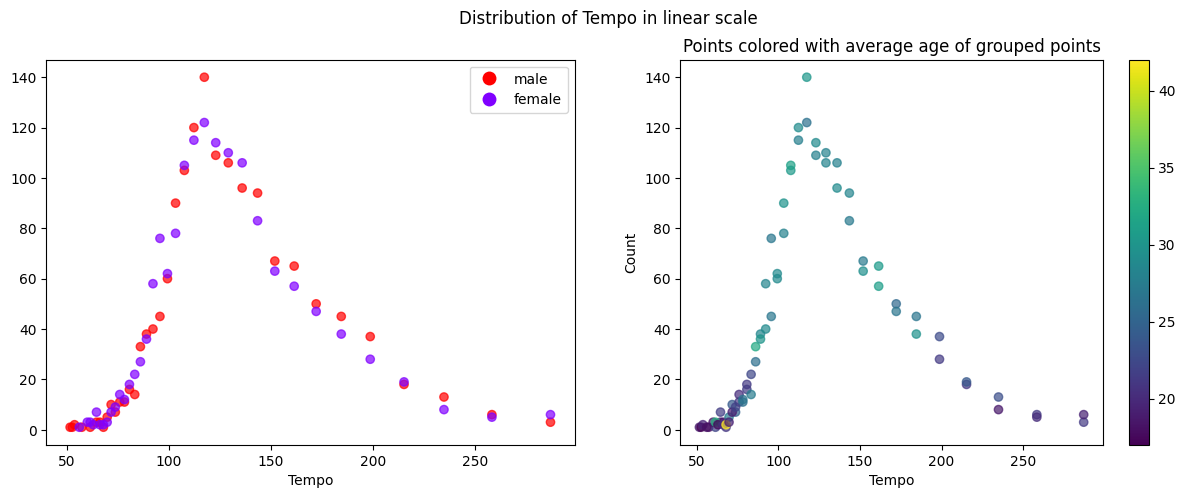

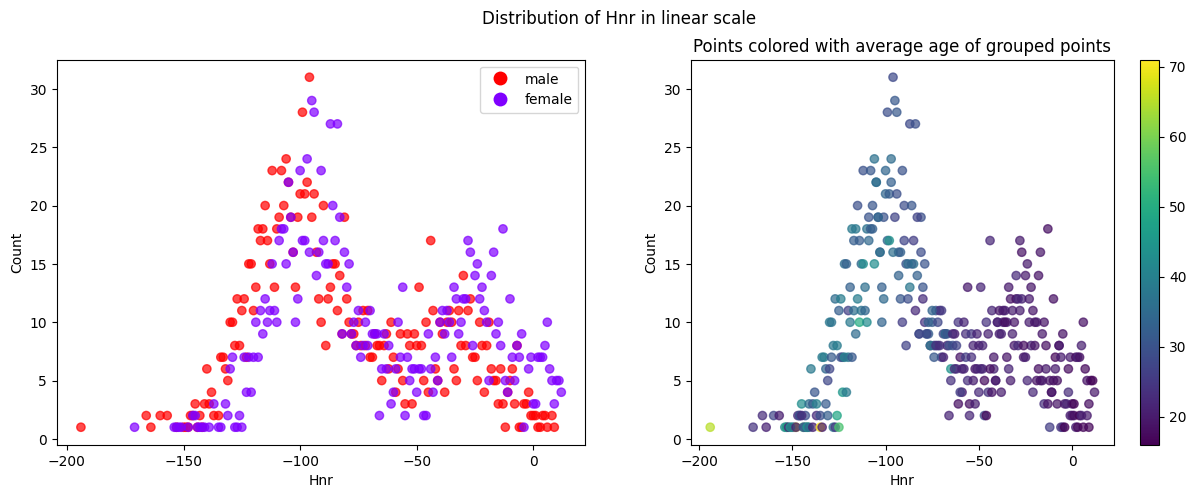

In [12]:
def create_colors(values:pd.Series, label:str, use_continous:bool=False, 
                  cmap_continuous = cm.viridis, cmap_discrete = cm.rainbow):
    if use_continous:
        cmap_ = cmap_continuous
        # Alternative normalization without iterquartile ranges:
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap_)
        handles = None
    else:
        cmap_ = cmap_discrete
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = None
        handles = [
            Line2D(
                [0], [0], marker='o', color='none', linestyle='None', 
                markeredgewidth=0, markerfacecolor=cmap_(norm(val)), 
                markersize=10, label=label
            ) for label, val in GenderMapper.items()
        ]

    return cmap_, norm, mappable, handles 

def round_column(data: pd.DataFrame, col: str, isLog:bool = True):
    if col != 'hnr':
        if isLog:
            rounded_col = np.round(
                np.log10(data[col]), 
                precisionLog[col]
            )
        else:
            rounded_col = np.round(
                data[col],
                precisionLinear[col]
            )
    else:
        rounded_col = np.round(data[col], precisionLinear[col])
    return rounded_col


def perform_aggregation(partition_df, target, gender, descrete):
    grouped_temp = partition_df.groupby(col).agg({
        'frequency': 'first',
    })

    if not descrete:
        grouped_temp['target'] = grouped_temp.index.map(
            lambda val: target.loc[partition_df[partition_df[col] == val].index, :].mean().iloc[0]
        )
    else:
        grouped_temp['target'] = GenderMapper[gender]

    grouped_temp = grouped_temp.reset_index()

    return grouped_temp
    
def plot_distribution(fig:plt.Figure, ax:plt.Axes, X_df:pd.DataFrame, col:str, target:pd.Series, isLog:bool=True, descrete:bool=False):    
    temp = X_df[['gender', col]].copy()

    temp[col] = round_column(temp, col, isLog=isLog)

    male_df = temp[temp['gender'] == GenderMapper['male']].copy()
    female_df = temp[temp['gender'] == GenderMapper['female']].copy()

    male_df['frequency'] = male_df[col].map(male_df[col].value_counts())
    female_df['frequency'] = female_df[col].map(female_df[col].value_counts())

    male_grouped_df = perform_aggregation(male_df, target, 'male', descrete)
    female_grouped_df = perform_aggregation(female_df, target, 'female', descrete)

    female_grouped_df.index = female_grouped_df.index + male_grouped_df.index[-1]

    combined_df = pd.concat([male_grouped_df, female_grouped_df]).reset_index()

    cmap_, norm, mappable, handles = create_colors(combined_df.loc[:, 'target'], label='gender', use_continous=not descrete)

    sc = ax.scatter(combined_df[col], 
                    combined_df['frequency'], 
                    c=cmap_(norm(combined_df['target'])), 
                    alpha=0.7)

    if mappable:
        fig.colorbar(mappable=mappable, ax=ax)
    else:
        ax.legend(handles=handles)

for i in range(9):
    col = list(precisionLog.keys())[i]
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f'Distribution of {col.capitalize()} in log10 scale')

    ax1 = fig.add_subplot(121)
    plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=True, descrete=True)
    ax1.set_xlabel(f'log_10({col.capitalize()})')
    ax1.set_ylabel(f'Count')
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("Points colored with average age of grouped points")

    plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=True, descrete=False)
    ax2.set_xlabel(f'log_10({col.capitalize()})')
    ax1.set_ylabel(f'Count')
    plt.show()

    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

    ax1 = fig.add_subplot(121)
    plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
    ax1.set_xlabel(f'{col.capitalize()}')
    ax2.set_ylabel(f'Count')
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("Points colored with average age of grouped points")
    plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
    ax2.set_ylabel(f'Count')
    ax2.set_xlabel(f'{col.capitalize()}')
    plt.show()


col = list(precisionLog.keys())[9]

fig = plt.figure(figsize=(15, 5))
fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

ax1 = fig.add_subplot(121)
plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
ax1.set_xlabel(f'{col.capitalize()}')
ax1.set_ylabel(f'Count')

ax2 = fig.add_subplot(122)
ax2.set_title("Points colored with average age of grouped points")
plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
ax2.set_xlabel(f'{col.capitalize()}')
ax2.set_ylabel(f'Count')
plt.show()

#### In practice

In [13]:
step3_log_dev_df = step3_dev_df.copy()
step3_log_eval_df = step3_eval_df.copy()

for i, toSub in zip(precisionLog.keys(), [1, 0, 0, 1, 1, 1, 1, 1, 0, 0]):
    if toSub == 1:
        step3_log_dev_df.loc[:, i] = np.log10(step3_dev_df.loc[:, i])
        step3_log_eval_df.loc[:, i] = np.log10(step3_eval_df.loc[:, i])

### Standardization

In [14]:
# step3_log_dev_df = step3_log_dev_df.copy().drop(columns=['ethnicity'], axis=1)
# step3_log_eval_df = step3_log_eval_df.copy().drop(columns=['ethnicity'], axis=1)

In [15]:
#TODO: only one scaler fitted on dev?

step3_log_norm_dev_df = pd.DataFrame(StandardScaler().fit_transform(step3_log_dev_df), index=step3_log_dev_df.index, columns=step3_log_dev_df.columns)
step3_log_norm_eval_df = pd.DataFrame(StandardScaler().fit_transform(step3_log_eval_df), index=step3_log_eval_df.index, columns=step3_log_eval_df.columns)

display(step3_log_norm_dev_df.head())
display(step3_log_norm_eval_df.head())

age    gender  ethnicity  mean_pitch  max_pitch  min_pitch    jitter  \
Id                                                                              
0  -0.297751 -0.998978  -0.495948    1.295444   0.413221  -0.400362 -1.298379   
1  -0.412333 -0.998978  -0.495948    0.406357   0.411611  -0.415793  0.754143   
2  -0.450527 -0.998978  -0.495948    0.476199   0.411505  -0.402148 -0.206386   
3  -0.450527 -0.998978   2.016341    0.661310   0.410845   0.278367 -0.592809   
4  -0.450527  1.001023  -0.495948    1.096713   0.411146  -0.395821  1.093041   

     shimmer    energy  zcr_mean  spectral_centroid_mean     tempo       hnr  \
Id                                                                             
0  -0.853814 -0.404445  1.534388                1.416622  0.796088 -1.287020   
1  -0.288687  0.855523 -0.277067               -0.777731  0.121675 -0.322635   
2   0.518159 -0.123477  0.258771                0.739585 -0.225751 -0.622378   
3  -0.057508  1.920345  1.182793                1.593684 -0.225751  0.469989   
4   0.682511  0.474725  0.292051               -0.295562 -0.376805 -0.151479   

    num_words  num_characters  num_pauses  silence_duration  
Id                                                           
0    0.844879        0.845057    1.862330          0.954642  
1    0.844879        0.845057    0.601010          0.543263  
2    0.844879        0.845057   -0.800455          0.751095  
3    0.844879        0.845057   -0.239869          0.566836  
4    0.844879        0.845057   -0.099722          0.418993

gender  ethnicity  mean_pitch  max_pitch  min_pitch    jitter   shimmer  \
Id                                                                              
0   0.870787        0.0   -0.179175   0.250505  -0.375152  0.268417  1.808076   
1   0.870787        0.0    0.259314   0.370296  -0.320065  0.928676  0.830861   
2   0.870787        0.0   -0.459636  -0.857811  -0.285977 -0.452130 -0.395503   
3  -1.148387        0.0    0.618579   0.369681  -0.367448  1.023972 -0.701578   
4   0.870787        0.0    1.067930   0.371608  -0.382744  0.193205 -0.105496   

      energy  zcr_mean  spectral_centroid_mean     tempo       hnr  num_words  \
Id                                                                              
0  -0.031080 -2.072636               -1.221902 -1.379883 -0.880041   0.783023   
1   0.728661  0.563774                0.344352 -1.127593  0.172598   0.783023   
2   0.319816 -0.091570               -0.373114 -0.102414  0.354112  -1.185978   
3   1.503010  0.077599               -0.588758 -0.102414 -0.465401   0.783023   
4  -0.847017  0.820588                0.638664 -0.425568 -1.380255   0.783023   

    num_characters  num_pauses  silence_duration  
Id                                                
0         0.783236   -0.808429          2.104343  
1         0.783236    0.666916          1.325451  
2        -1.196300   -0.808429         -1.151785  
3         0.783236    0.902971          0.649841  
4         0.783236    1.139026          0.675097

## Correlation

age                 1.000000
silence_duration    0.514127
num_words           0.473499
num_characters      0.473403
num_pauses          0.437670
mean_pitch          0.327427
zcr_mean            0.313140
jitter              0.270149
ethnicity           0.249463
max_pitch           0.226643
Name: age, dtype: float64

jitter                    0.270149
ethnicity                 0.249463
max_pitch                 0.226643
shimmer                   0.223070
energy                    0.146518
spectral_centroid_mean    0.056151
gender                    0.023184
tempo                    -0.040547
min_pitch                -0.224201
hnr                      -0.446880
Name: age, dtype: float64

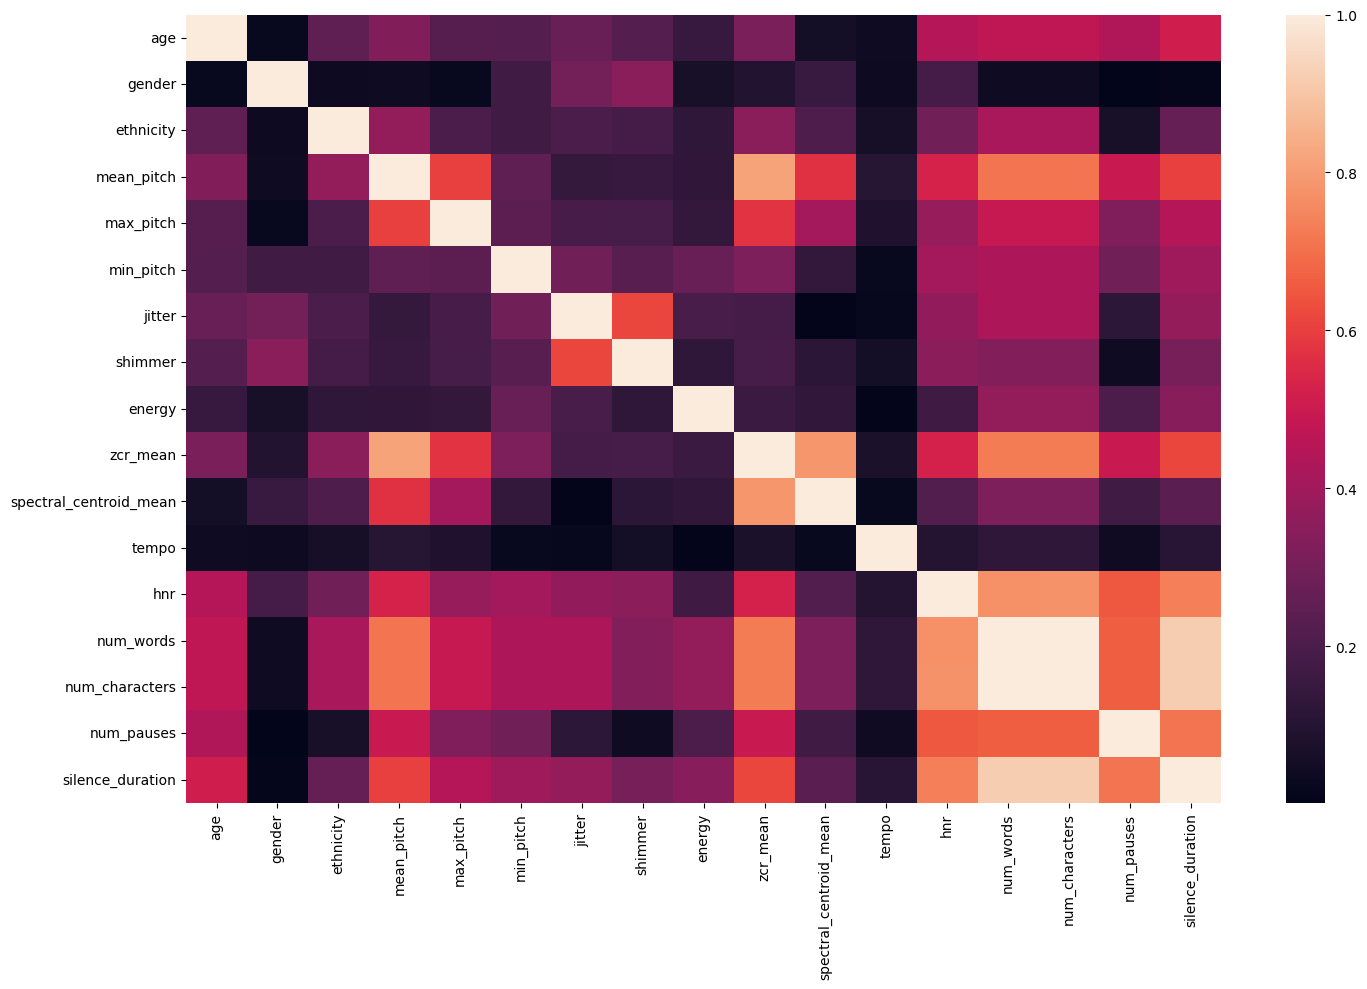

In [16]:
temp:pd.Series = step3_log_norm_dev_df.corr().loc['age', :].sort_values(ascending=False)
display(temp.head(10))
display(temp.tail(10))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
sns.heatmap(np.abs(step3_log_norm_dev_df.corr()), ax=ax)
plt.tight_layout()


## Error plot

In [17]:
def plot_error_distripution(y_pred, y_val, precision):
    errors = pd.DataFrame(np.round(y_pred.flatten() - y_val.values.flatten(), precision), columns=['error'])
    error_counts = errors['error'].value_counts().reset_index()
    error_counts.columns = ['error', 'count']

    plt.figure()
    plt.scatter(error_counts['error'], error_counts['count'])
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Errors')
    plt.show()
    return error_counts

## First regressor

10.61268570688483

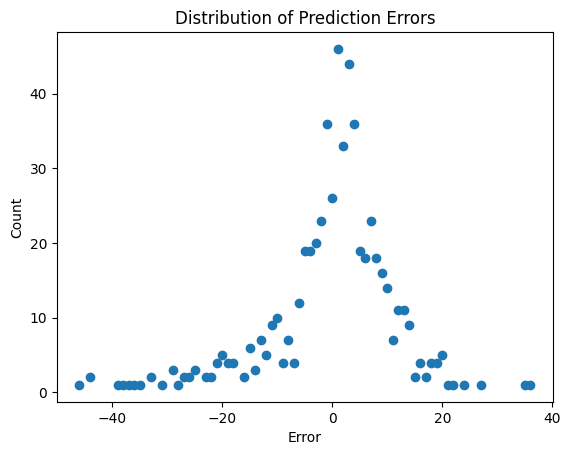

In [18]:
X_train_val_df = step3_log_norm_dev_df.copy()
X_train_val_df = X_train_val_df.drop(columns=['age', 'gender', 'num_words', 'num_characters'], axis=1)

forest = RandomForestRegressor(random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.455056281368881

First look to feature importances

In [19]:
sorted(zip(forest.feature_names_in_, forest.feature_importances_), key=lambda x:x[1] , reverse=True)

[('silence_duration', np.float64(0.3406440953507401)),
 ('hnr', np.float64(0.0692492323986667)),
 ('jitter', np.float64(0.0668275220669987)),
 ('num_pauses', np.float64(0.06068703358173029)),
 ('spectral_centroid_mean', np.float64(0.05864754535259559)),
 ('mean_pitch', np.float64(0.05797047941493507)),
 ('energy', np.float64(0.05691709942884412)),
 ('min_pitch', np.float64(0.0561214891792567)),
 ('shimmer', np.float64(0.05466056137580196)),
 ('max_pitch', np.float64(0.05323717159047552)),
 ('zcr_mean', np.float64(0.047503897887433616)),
 ('tempo', np.float64(0.039702053709352335)),
 ('ethnicity', np.float64(0.03783181866316922))]

As we can see, only ethnicity "english" seems to give a significant contribution to regressor

In [20]:
step3_log_norm_eval_df.head()

gender  ethnicity  mean_pitch  max_pitch  min_pitch    jitter   shimmer  \
Id                                                                              
0   0.870787        0.0   -0.179175   0.250505  -0.375152  0.268417  1.808076   
1   0.870787        0.0    0.259314   0.370296  -0.320065  0.928676  0.830861   
2   0.870787        0.0   -0.459636  -0.857811  -0.285977 -0.452130 -0.395503   
3  -1.148387        0.0    0.618579   0.369681  -0.367448  1.023972 -0.701578   
4   0.870787        0.0    1.067930   0.371608  -0.382744  0.193205 -0.105496   

      energy  zcr_mean  spectral_centroid_mean     tempo       hnr  num_words  \
Id                                                                              
0  -0.031080 -2.072636               -1.221902 -1.379883 -0.880041   0.783023   
1   0.728661  0.563774                0.344352 -1.127593  0.172598   0.783023   
2   0.319816 -0.091570               -0.373114 -0.102414  0.354112  -1.185978   
3   1.503010  0.077599               -0.588758 -0.102414 -0.465401   0.783023   
4  -0.847017  0.820588                0.638664 -0.425568 -1.380255   0.783023   

    num_characters  num_pauses  silence_duration  
Id                                                
0         0.783236   -0.808429          2.104343  
1         0.783236    0.666916          1.325451  
2        -1.196300   -0.808429         -1.151785  
3         0.783236    0.902971          0.649841  
4         0.783236    1.139026          0.675097

In [21]:
y_eval_pred = forest.predict(X_train_val_df.values)

display(np.max(y_eval_pred), np.min(y_eval_pred))
display(np.max(ages_df), np.min(ages_df))

np.float64(80.43)

np.float64(15.69)

np.float64(97.0)

np.float64(6.0)

In [22]:
abs(
    cross_val_score(
        RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=341967), 
        X_train_val_df, 
        ages_df, cv=10, 
        scoring='neg_root_mean_squared_error', 
        n_jobs=-1
    ).mean()
)

np.float64(10.627389425729998)

## Fine tuned

10.584938271176576

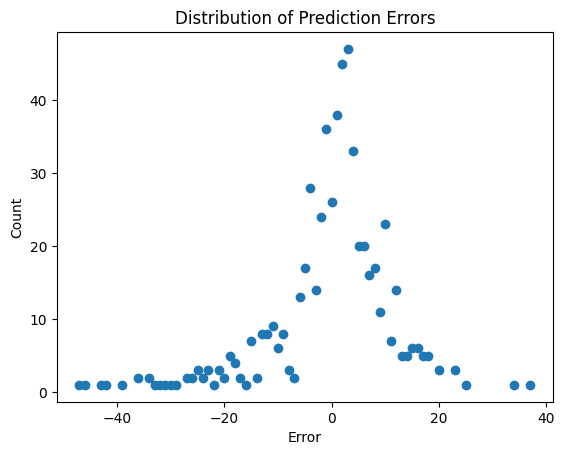

In [23]:
def grid(builder, configs, cv):
    gs = GridSearchCV(builder(), configs, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)
    gs.fit(X_train.values, y_train.values.reshape((-1,)))
    
    return gs

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

best = grid(RandomForestRegressor, {'n_estimators': [300, 500], 'random_state': [341967]}, 5)

y_pred = best.predict(X_val.values)

display(root_mean_squared_error(y_val, y_pred))
_ = plot_error_distripution(y_pred, y_val, 0)

#10.424189101247185

## Preprocess audio

### Data exploration

In [24]:
def plot_audio(y:np.ndarray, sr:float, time=False, freq=False, spectrogram=False, mel=False, mfcc=False, hp=False):
    """
        Returns the thing plotted\n
        If freq = True, returns the frequencies used too\n
        If hp=True, returns Harmonic and Percussion\n
        If all False, returns y
    """

    if time:
        plt.figure(figsize=(12, 3))
        plt.title(f"Audio {i} as waveform")
        librosa.display.waveshow(y, sr=sr)

        return y
    if freq:
        y_freq = np.abs(scipy.fft.fft(y))

        f = np.linspace(0, sr, len(y_freq))

        plt.figure(figsize=(12, 3))
        plt.title(f"Spectrum of audio {i}")
        plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
        plt.xlabel("Frequency (Hz)")

        return y_freq, f
    if spectrogram:
        y_stft = np.abs(librosa.stft(y))
        y_stft = librosa.amplitude_to_db(y_stft, ref=np.max)

        plt.figure(figsize=(12, 4))
        plt.title(f"Spectrogram of audio {i}")
        librosa.display.specshow(y_stft, sr=sr, x_axis="time", y_axis="log")
        plt.colorbar(format="%.1f dB")

        return y_stft
    if mel:
        y_mel = librosa.feature.melspectrogram(y=y, sr=sr)
        y_mel = librosa.power_to_db(y_mel, ref=np.max)

        plt.figure(figsize=(12, 4))
        plt.title(f"Mel-spectrogram of audio {i}")
        librosa.display.specshow(y_mel, sr=sr, x_axis="time", y_axis="mel")
        plt.colorbar(format="%.2f dB")
        
        return y_mel
    if mfcc:
        y_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        plt.figure(figsize=(12, 4))
        plt.title(f"MFCC of audio {i}")
        librosa.display.specshow(y_mfccs, sr=sr, x_axis="time")
        plt.colorbar()

        return y_mfccs
    if hp:
        y_stft = librosa.stft(y)
        H, P = librosa.decompose.hpss(y_stft)

        Hmag = librosa.amplitude_to_db(H, ref=np.max)
        Pmag = librosa.amplitude_to_db(P, ref=np.max)
        
        plt.figure(figsize=(12, 4))
        plt.title(f"Harmonic source of audio {i}")
        librosa.display.specshow(Hmag, sr=sr, x_axis="time", y_axis="mel")
        plt.colorbar(format="%.2f dB")

        plt.figure(figsize=(12, 4))
        plt.title(f"Percussive source of audio {i}")
        librosa.display.specshow(Pmag, sr=sr, x_axis="time", y_axis="mel")
        plt.colorbar(format="%.2f dB")

        return librosa.istft(H), librosa.istft(P)
    plt.show()

    return y

In [25]:
test_audios = np.random.choice(audio_dev, 3)

#### Time domain

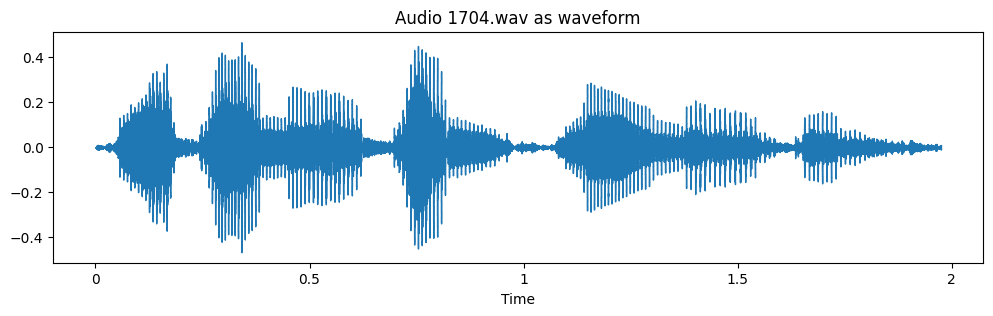

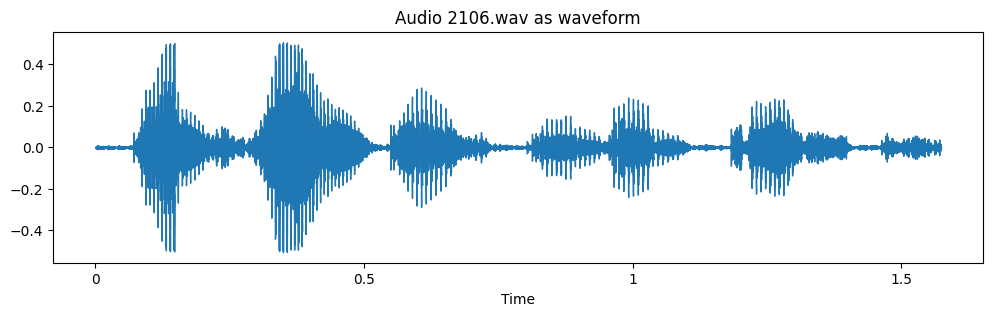

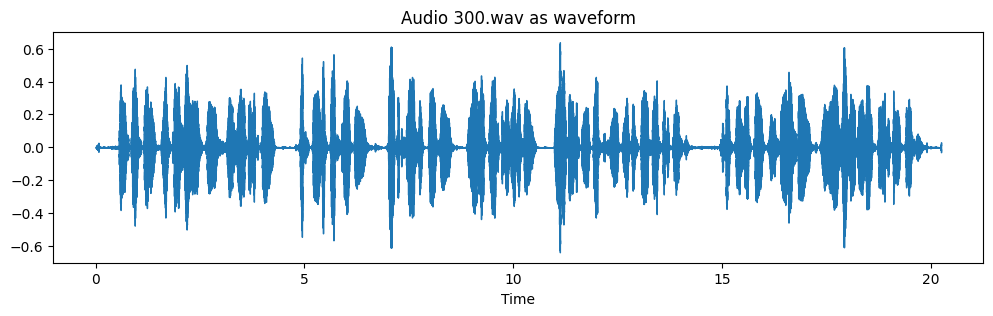

In [26]:
for i in test_audios:
    y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

    plot_audio(y, sr, time=True)

#### Frequency domain

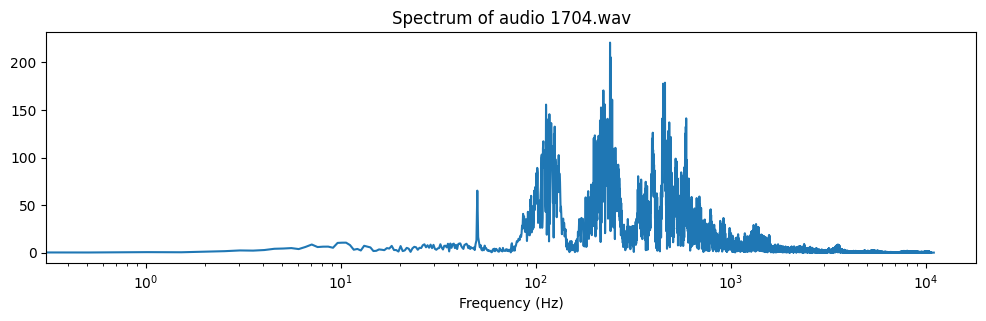

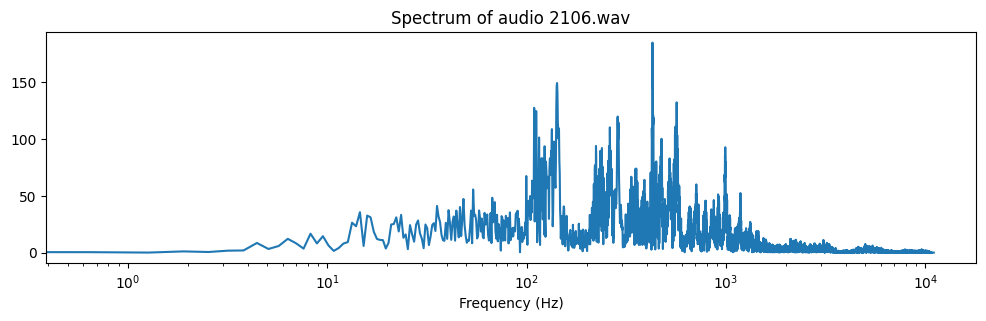

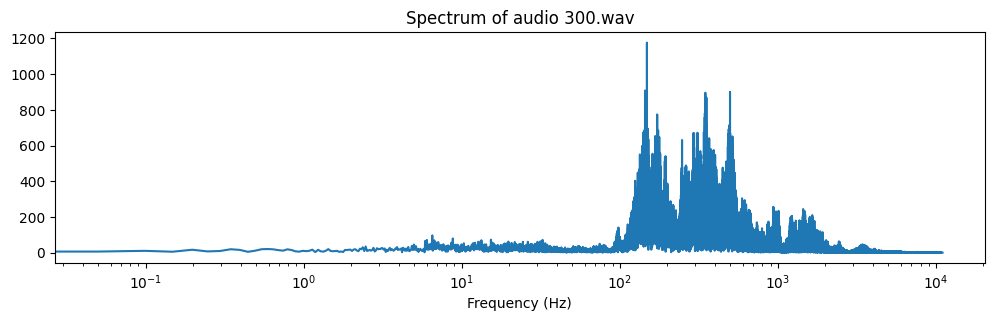

In [27]:
for i in test_audios:
    y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

    plot_audio(y, sr, freq=True)

#### Spectrogram

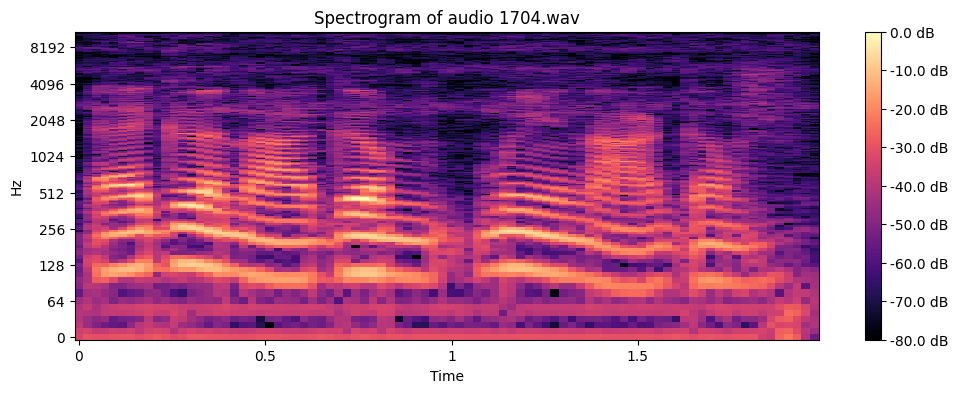

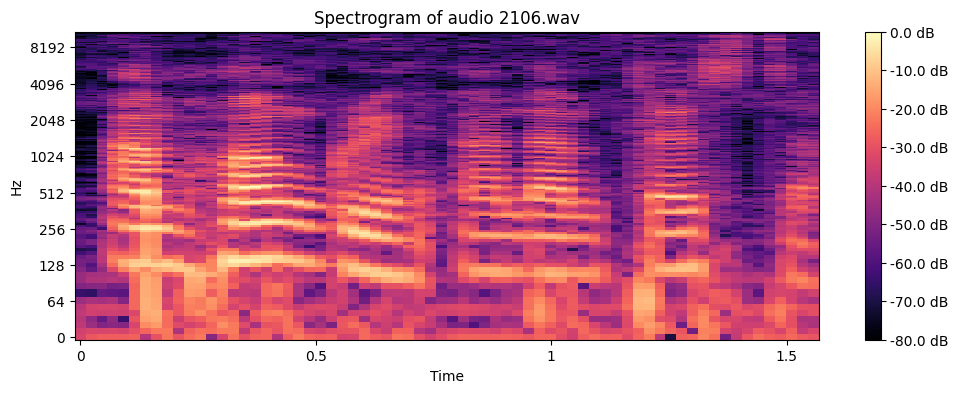

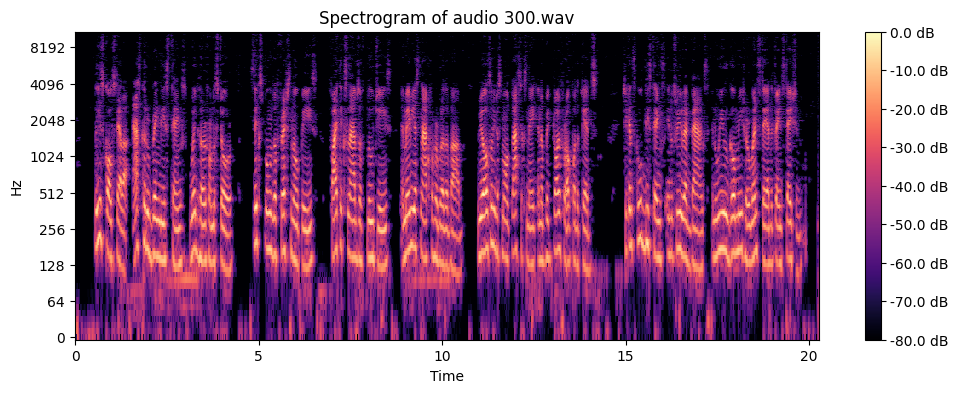

In [28]:
for i in test_audios:
    y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

    plot_audio(y, sr, spectrogram=True)

#### Mel-spectrogram

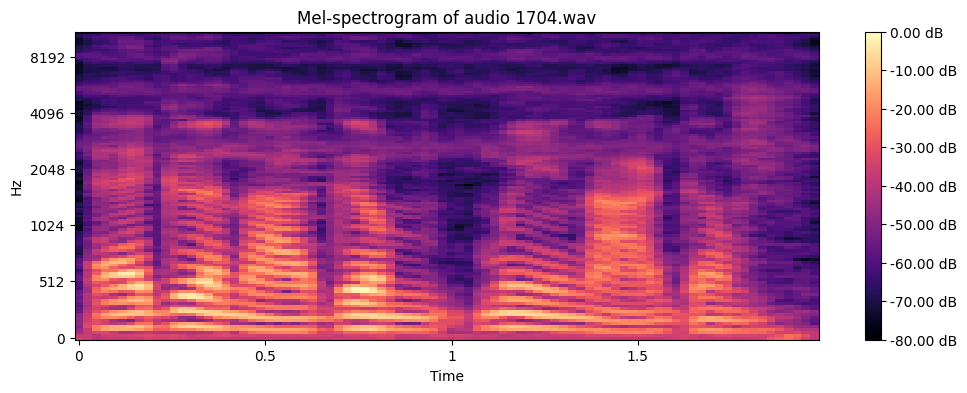

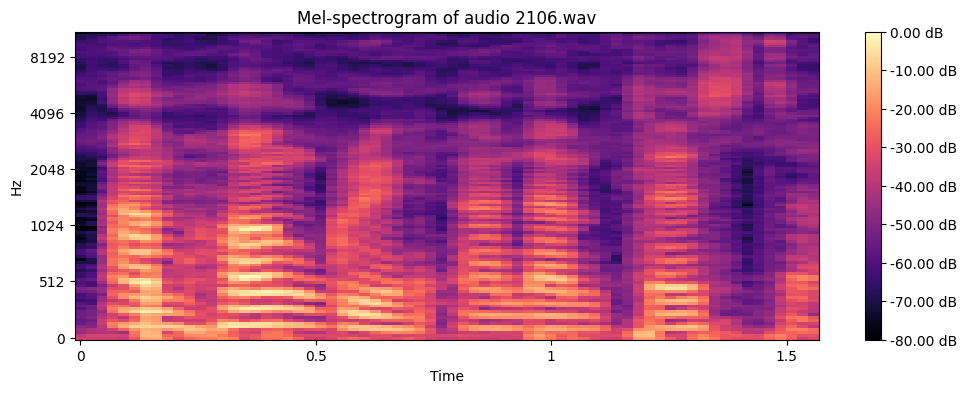

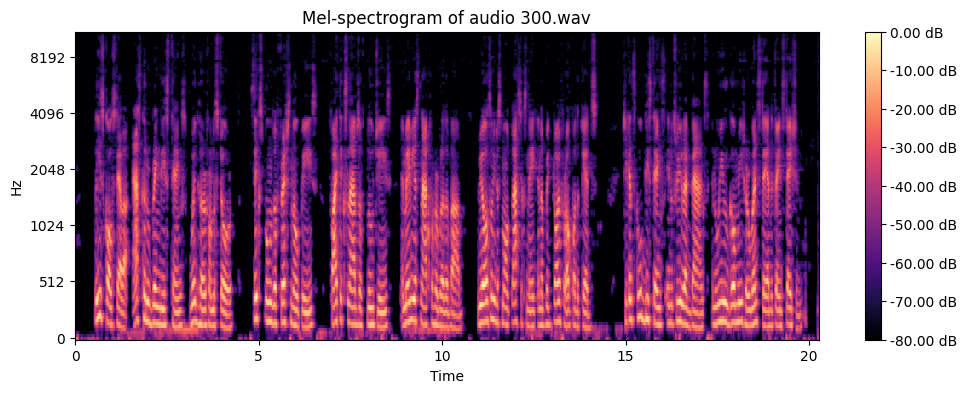

In [29]:
for i in test_audios:
    y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

    plot_audio(y, sr, mel=True)

#### Mel-frequency cepstral coefficients (MFCC)

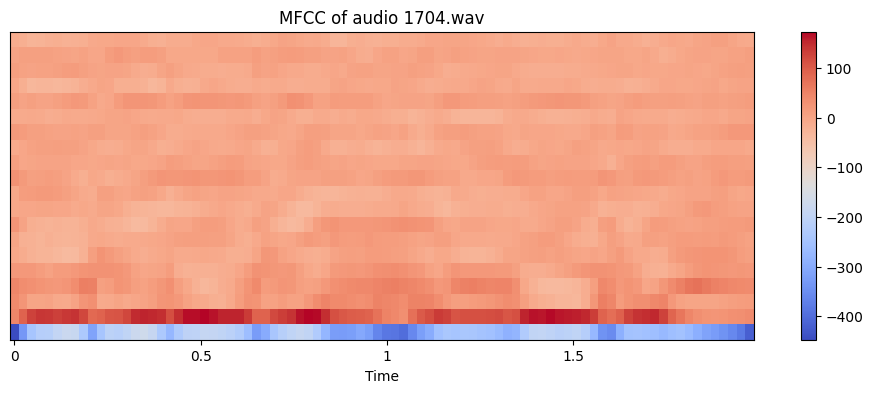

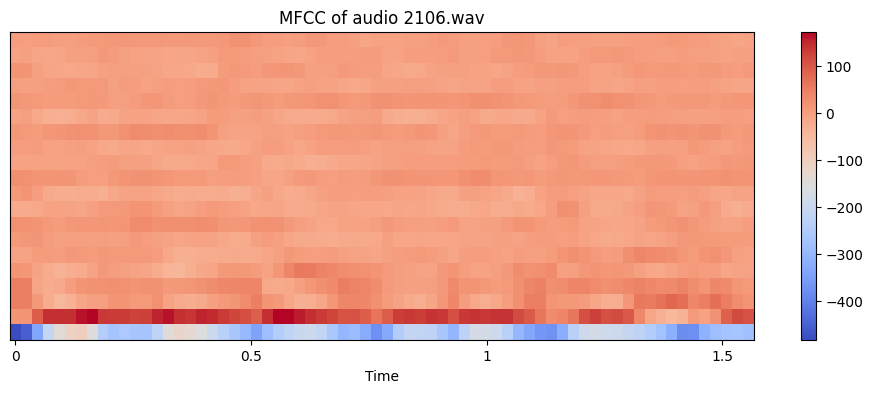

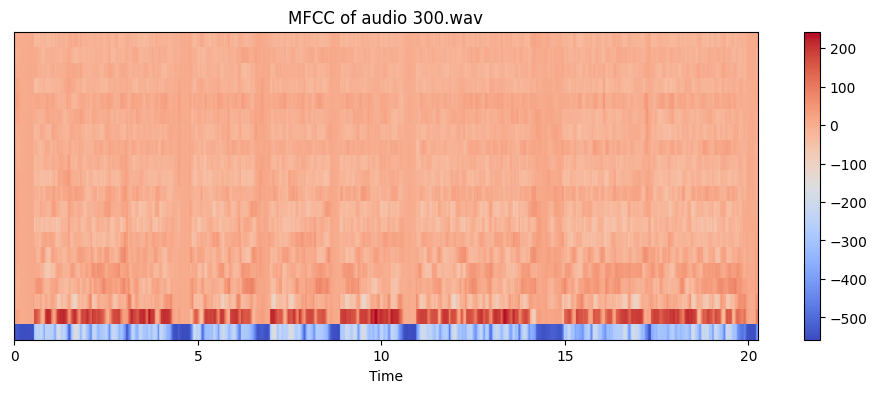

In [30]:
for i in test_audios:
    y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

    plot_audio(y, sr, mfcc=True)

#### Harmonic-percussive source separation

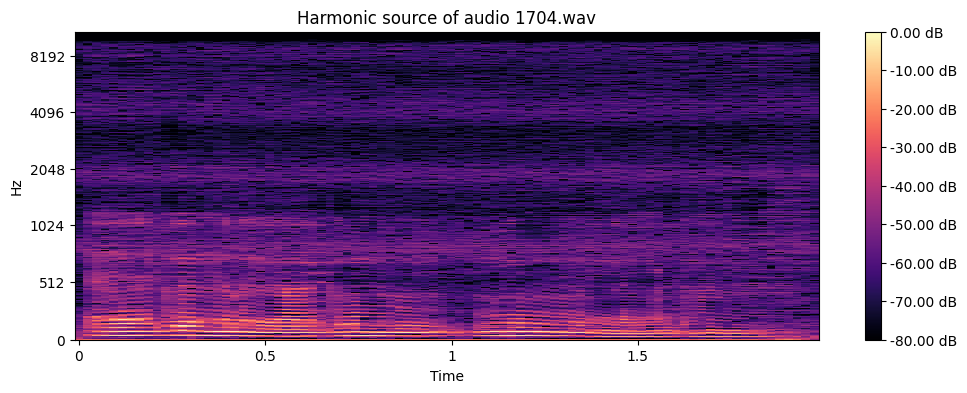

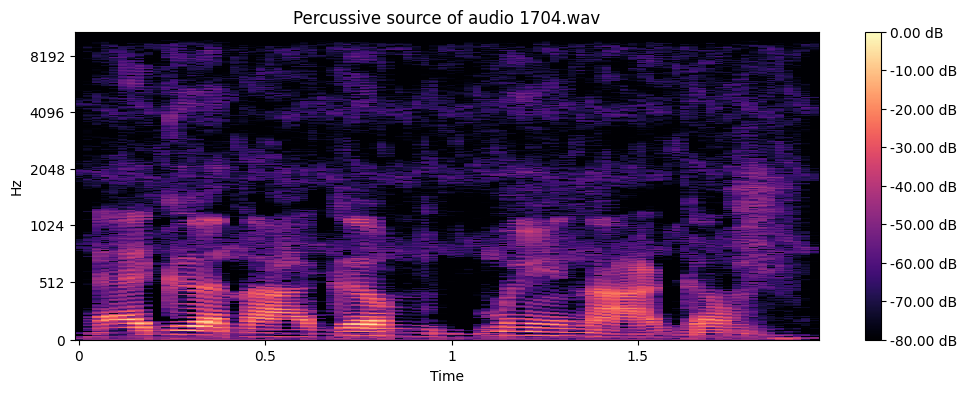

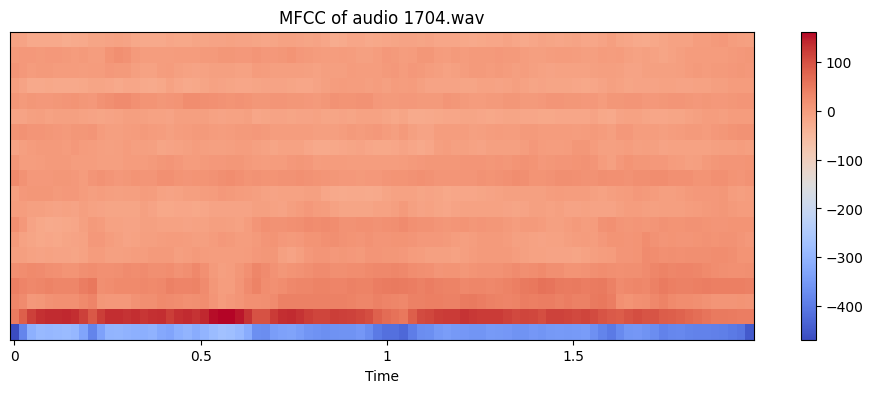

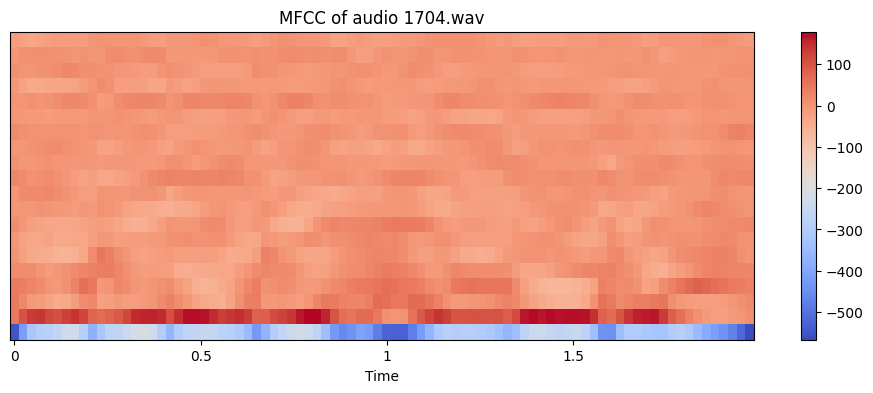

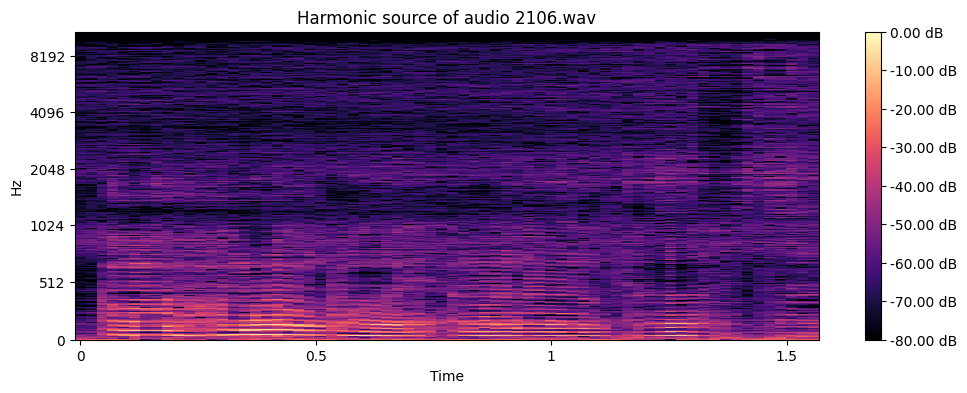

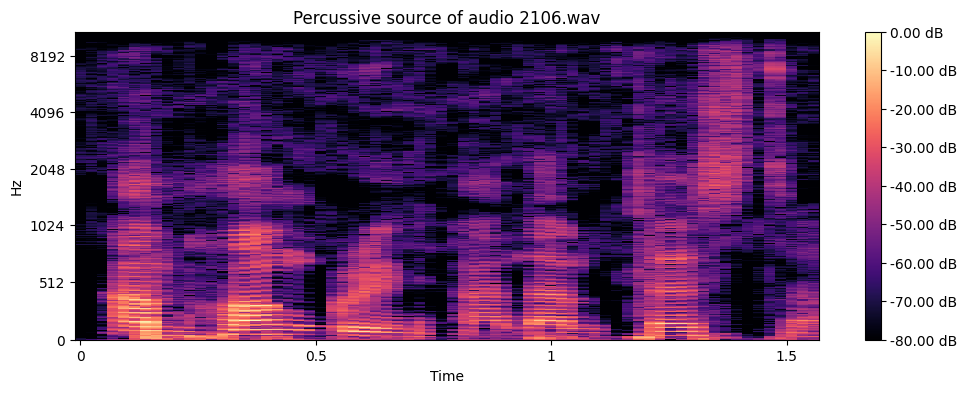

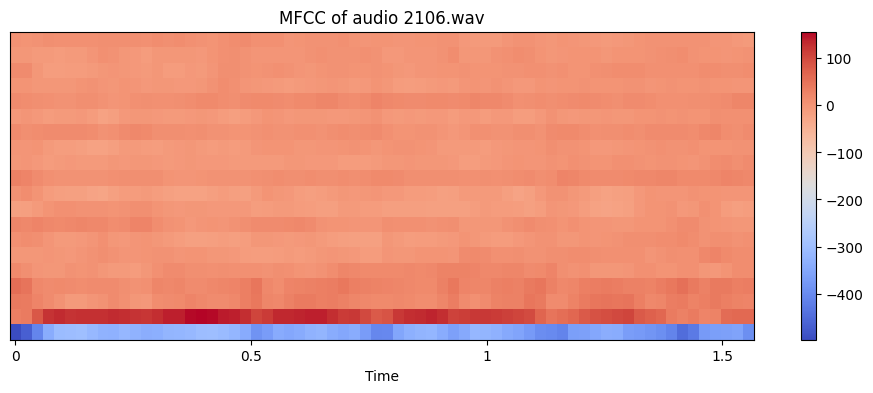

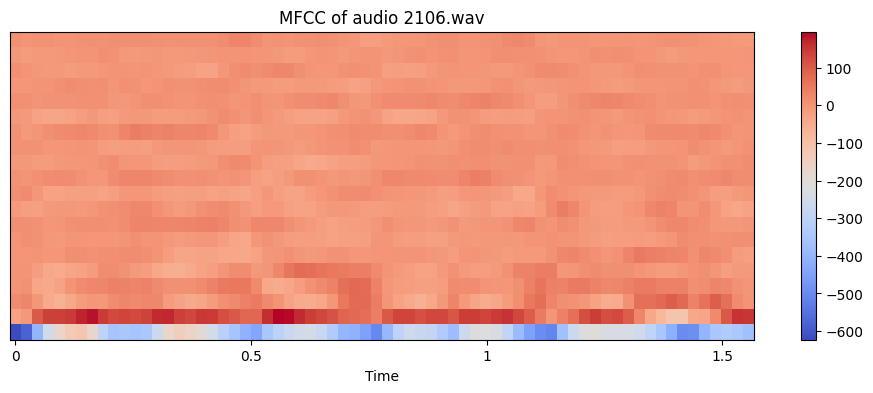

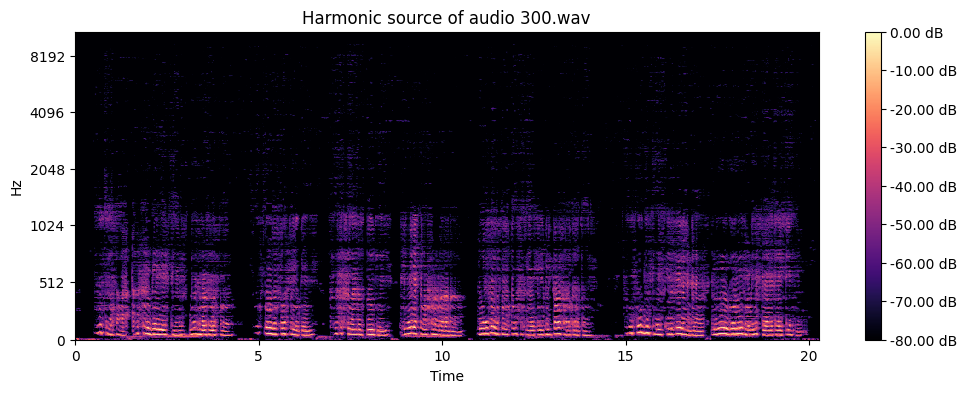

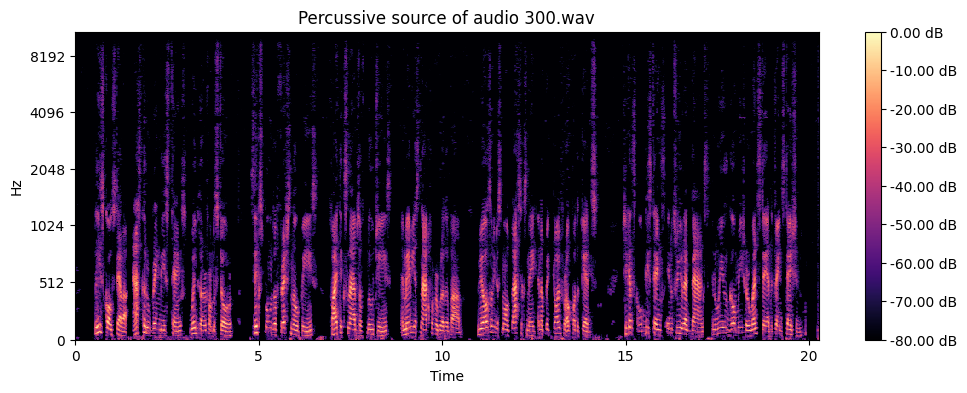

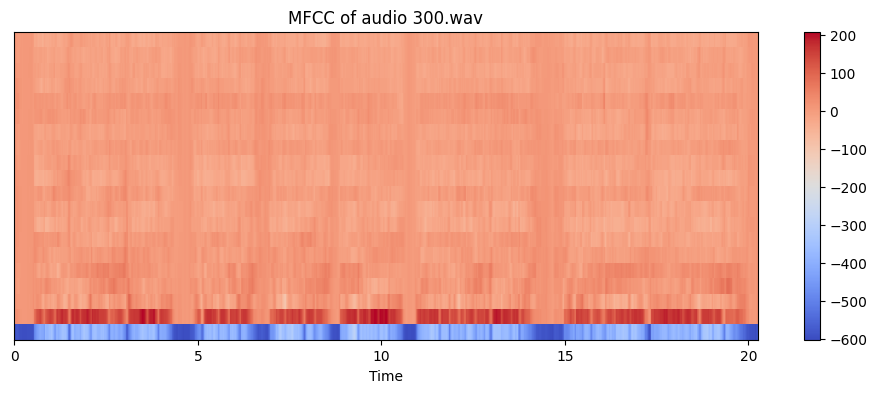

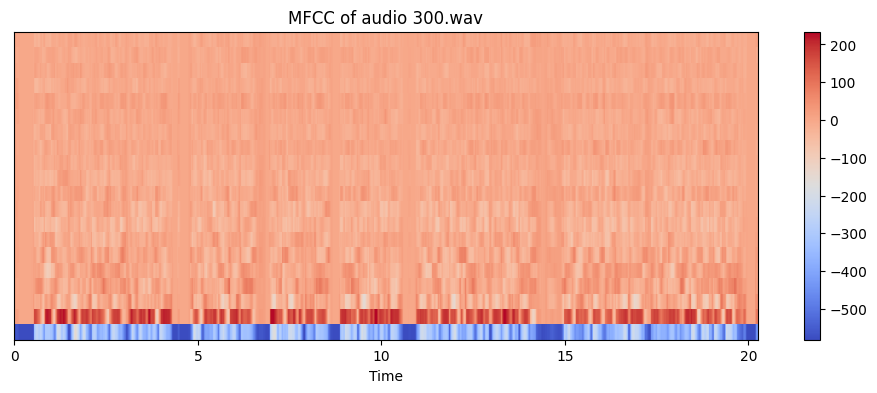

In [31]:
for i in test_audios:
    y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

    h, p = plot_audio(y, sr, hp=True)

    plot_audio(h, sr, mfcc=True)
    plot_audio(p, sr, mfcc=True)

#### Zero-crossing rate

In [32]:
for i in test_audios:
    y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

    zero_astfly = librosa.zero_crossings(y, pad=False).sum()

    display(zero_astfly)

np.int64(2432)

np.int64(2926)

np.int64(39160)

# Upload section

In [33]:
y_eval_pred = forest.predict(step3_log_norm_eval_df.drop(columns=['gender', 'num_words', 'num_characters'], axis=1))

with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")